In [2]:
import drjit as dr
from drjit.cuda import Float, UInt32, Array3f, Array2f, TensorXf, Texture3f, PCG32, Loop


In [3]:
def sdf(p: Array3f) -> Float:
    return dr.norm(p) - 1

In [4]:
sdf(Array3f(1, 2, 3))

[2.7416574954986572]

In [5]:
sdf(Array3f([0, 1], [0, 2], [0, 3]))

[-1.0, 2.741657257080078]

In [6]:
def trace(o: Array3f, d: Array3f) -> Array3f:
    for i in range(10):
        o = dr.fma(d, sdf(o), o)#fma(a,b,c)=a*b+c
    return o

In [7]:
def shade(p: Array3f, l: Array3f, eps: float = 1e-3) -> Float:
    n = Array3f(
        sdf(p + [eps, 0, 0]) - sdf(p - [eps, 0, 0]),
        sdf(p + [0, eps, 0]) - sdf(p - [0, eps, 0]),
        sdf(p + [0, 0, eps]) - sdf(p - [0, 0, eps])
    ) / (2 * eps)
    return dr.maximum(0, dr.dot(n, l))

In [8]:
x = dr.linspace(Float, -1, 1, 1000)
x,y = dr.meshgrid(x, x)

In [9]:
#相机射线与球面交点
p = trace(o=Array3f(0, 0, -2),
          d=dr.normalize(Array3f(x, y, 1)))

In [10]:
sh = shade(p, l=Array3f(0, -1, -1))
sh[sdf(p) > .1] = 0 #非交点为0

In [11]:
img = Array3f(.1, .1, .2) + Array3f(.4, .4, .2) * sh

In [12]:
img_flat = dr.ravel(img)

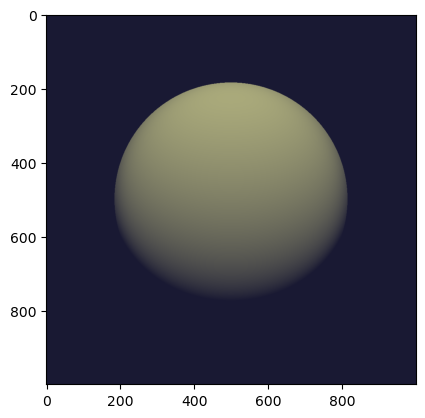

In [13]:
img_t = TensorXf(img_flat, shape=(1000, 1000, 3))

import matplotlib.pyplot as plt
plt.imshow(img_t)
plt.show()

In [14]:
noise = PCG32(size=16*16*16).next_float32()

In [15]:
noise_tex = Texture3f(TensorXf(noise, shape=(16, 16, 16, 1)))

### 加noise的渲染

In [16]:
def sdf(p: Array3f) -> Float:
    sdf_value = dr.norm(p) - 1
    sdf_value += noise_tex.eval(dr.fma(p, 0.5,  0.5))[0] * 0.1
    return sdf_value

In [17]:
# Dr.Jit 在编译和运行内核时可以发出一条简短的消息
dr.set_log_level(dr.LogLevel.Info)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


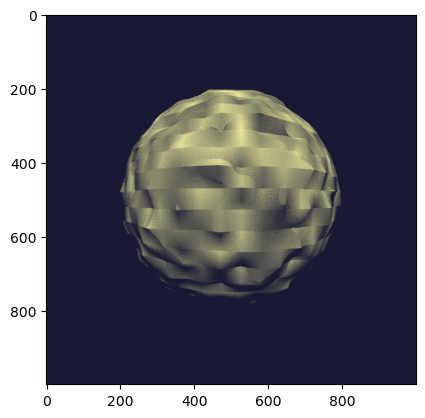

In [18]:
def trace(o: Array3f, d: Array3f) -> Array3f:
    for i in range(10):
        o = dr.fma(d, sdf(o), o)
    return o

def shade(p: Array3f, l: Array3f, eps: float = 1e-3) -> Float:
    n = Array3f(
        sdf(p + [eps, 0, 0]) - sdf(p - [eps, 0, 0]),
        sdf(p + [0, eps, 0]) - sdf(p - [0, eps, 0]),
        sdf(p + [0, 0, eps]) - sdf(p - [0, 0, eps])
    ) / (2 * eps)
    return dr.maximum(0, dr.dot(n, l))

x = dr.linspace(Float, -1, 1, 1000)
x, y = dr.meshgrid(x, x)

p = trace(o=Array3f(0, 0, -2),
          d=dr.normalize(Array3f(x, y, 1)))

sh = shade(p, l=Array3f(0, -1, -1))
sh[sdf(p) > .1] = 0

img = Array3f(.1, .1, .2) + Array3f(.4, .4, .2) * sh
img_flat = dr.ravel(img)

img_t = TensorXf(img_flat, shape=(1000, 1000, 3))

import matplotlib.pyplot as plt
plt.imshow(img_t)
plt.show()

### 高阶插值法向

jit_eval(): launching 1 kernel.
  -> launching e5aa80752ff86f6b (n=4096, in=0, out=1, ops=41, jit=13.3 us):
jit_eval(): done.


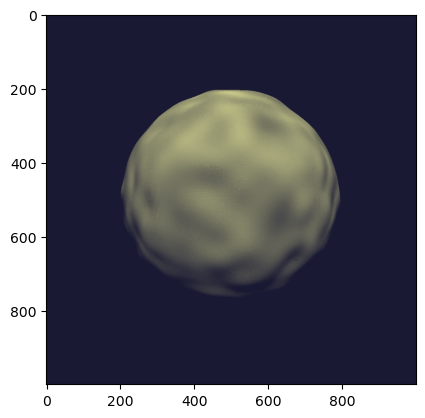

In [19]:
import drjit as dr
from drjit.cuda import Float, UInt32, Array3f, Array2f, TensorXf, Texture3f, PCG32, Loop

dr.set_log_level(dr.LogLevel.Info)

noise = PCG32(size=16*16*16).next_float32()
noise_tex = Texture3f(TensorXf(noise, shape=(16, 16, 16, 1)))

def sdf(p: Array3f) -> Float:
    sdf_value = dr.norm(p) - 1
    #高阶插值
    sdf_value += noise_tex.eval_cubic(dr.fma(p, 0.5,  0.5))[0] * 0.1
    return sdf_value

def trace(o: Array3f, d: Array3f) -> Array3f:
    for i in range(10):
        o = dr.fma(d, sdf(o), o)
    return o

def shade(p: Array3f, l: Array3f, eps: float = 1e-3) -> Float:
    n = Array3f(
        sdf(p + [eps, 0, 0]) - sdf(p - [eps, 0, 0]),
        sdf(p + [0, eps, 0]) - sdf(p - [0, eps, 0]),
        sdf(p + [0, 0, eps]) - sdf(p - [0, 0, eps])
    ) / (2 * eps)
    return dr.maximum(0, dr.dot(n, l))

x = dr.linspace(Float, -1, 1, 1000)
x, y = dr.meshgrid(x, x)

p = trace(o=Array3f(0, 0, -2),
          d=dr.normalize(Array3f(x, y, 1)))

sh = shade(p, l=Array3f(0, -1, -1))
sh[sdf(p) > .1] = 0

img = Array3f(.1, .1, .2) + Array3f(.4, .4, .2) * sh
img_flat = dr.ravel(img)

img_t = TensorXf(img_flat, shape=(1000, 1000, 3))

import matplotlib.pyplot as plt
plt.imshow(img_t)
plt.show()


### 高效的代码

In [20]:
from drjit.cuda.ad import Float, UInt32, Array3f, Array2f, TensorXf, Texture3f, PCG32, Loop


修改循环

In [21]:
# Improved version
def trace(o: Array3f, d: Array3f) -> Array3f:
    i = UInt32(0)
    loop = Loop("Sphere tracing", lambda: (o, i))# 获取loop中修改的变量
    while loop(i < 10):#将loop视作数组
        o = dr.fma(d, sdf(o), o)
        i += 1
    return o

自动微分

In [22]:
# Improved version
def shade(p: Array3f, l: Array3f) -> Float:
    dr.enable_grad(p)
    value = sdf(p)
    dr.set_grad(p, l)#方向导数
    dr.forward_to(value)
    return dr.maximum(0, dr.grad(value))

jit_eval(): launching 1 kernel.
  -> launching e5aa80752ff86f6b (n=4096, in=0, out=1, ops=41, jit=16.2 us):
jit_eval(): done.


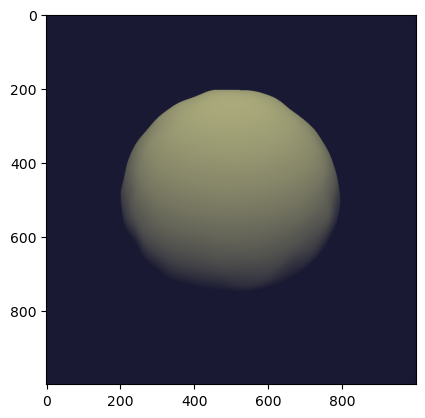

In [23]:
dr.set_log_level(dr.LogLevel.Info)

noise = PCG32(size=16*16*16).next_float32()
noise_tex = Texture3f(TensorXf(noise, shape=(16, 16, 16, 1)))

def sdf(p: Array3f) -> Float:
    sdf_value = dr.norm(p) - 1
    sdf_value += noise_tex.eval_cubic(dr.fma(p, 0.5,  0.5))[0] * 0.1
    return sdf_value

def trace(o: Array3f, d: Array3f) -> Array3f:
    i = UInt32(0)
    loop = Loop("Sphere tracing", lambda: (o, i))
    while loop(i < 10):
        o = dr.fma(d, sdf(o), o)
        i += 1
    return o

def shade(p: Array3f, l: Array3f, eps: float = 1e-3) -> Float:
    dr.enable_grad(p)
    value = sdf(p);
    dr.set_grad(p, l)
    dr.forward_to(value)
    return dr.maximum(0, dr.grad(value))

x = dr.linspace(Float, -1, 1, 1000)
x, y = dr.meshgrid(x, x)

p = trace(o=Array3f(0, 0, -2),
          d=dr.normalize(Array3f(x, y, 1)))

sh = shade(p, l=Array3f(0, -1, -1))
sh[sdf(p) > .1] = 0

img = Array3f(.1, .1, .2) + Array3f(.4, .4, .2) * sh
img_flat = dr.ravel(img)

img_t = TensorXf(img_flat, shape=(1000, 1000, 3))

import matplotlib.pyplot as plt
plt.imshow(img_t)
plt.show()